# Travel Time Estimate

## Question: Build a model to predict the travel time given start position, end position and start timestamp. 

The datasets include start positions (start_lng, start_lat), end positions (end_lng, end_lat), start timestamp and durations of the rides. 

First I did some exploration analysis for the start positions and end positions. Start positions and end positions are in longitude and latitude numbers, those numbers are in Manhattan region. The longitude and latitude numbers are in six decimal places. Since there are about 12.9 M records in train dataset and over 1.4 M records in test dataset, it is really heavy calculation in a laptop without big data framework. 

Next I did some exploration analysis for the start timestamps. The start timestamps are between 1/1/2015 and 1/1/2016. It spans a year in time period. For the timestamp, I differentiated them by is_holiday, is_weekend and is_rushhour. I believe the traffic in holiday and not in holiday are different, the traffic in weekend and not in weekend are different and the traffic in rushhour and not rushhour are different. 

### The first approach

After that, I can use the start positions, end positions, is_holiday, is_weekend, and is_rushhour as features to build a K-Nearest Neighbors Regression model to prediction the new travel time for a travel. The assumption of this model is the travel time from the same/close start position to the same/close end position during similar time (in the sense of holiday, weekend, rushhour) will be the same.

This calculation is really time consuming. It did not finish training for about 1.0 M train data after about 1.5 hours. Due to the time limit, I considered the second approach.   

### The second approach

Then I tried to use RandomForestRegressor to do the prediction. For this, I added two additional features, diff_lng and diff_lat to indicate the difference in longitude between start and end position and the difference between start and end latitude between the start and end position.

This calculation is also really time consuming. It did not finish training for about 1.0 M data after 1.5 hours. Due to the time limit, I considered the third approach.

### The third approach

Due to the large data set and time limit, KNNRegressor and RandomForestRegressor did not work in the situation to finish the work. I switched to Linear Regression as it is the least computional intensive approach.

In order to have good predictions, I created dummy variables after round longitude and latitude numbers into two decimal places. Then I created a dummy variable for each of the longitude and latitude numbers in the dataset. In total I have hundreds of features, such as is_holiday, is_weekend, is_rushhour, start_lng_-7401, start_lat_4074, ... I dropped the start_lng, start_lat, end_lng and end_lat after creating these dummy features.

I first used the Linear Regression to have a base line for the estimate using just diff_lng, diff_lat, is_holiday, is_weekend, and is_rushhour. After that, I used 20% of the train data with all the dummy position features and is_holiday, is_weekend, and is_rushhour to train a linear model. The 20% training data are splitted to train_data and validation_data. With this benchmark, I have MAE of 280 seconds for estimated arrival time for the validation_data.  

20% of the train data is the limit for my computational power. I can not do RidgeCV or use more train data for the prediction. In order to have better prediction, I tried to have an ensemble of estimates by running 20% of the train data and splitted them to train_data and validation_data multiply times. As ensemble methods will reduce the variance of the predictions, the final results are the averages of these estimates. 

Due to time limitation and computational power limitation, I did not do regularization and cross validation to have better predictions with RidgeCV.

### Remark

Due to the large dataset, contrained time limit and laptop computational power, the results I reported are not the best results I will achieve. There are a lot of more things which can be done if I had more time, such as better better cross validation and feature selection using RidgeCV.

If I can have other resources, I can map the start positions, end positions to understand more about these positions and to create more meaningful features. I can also do more analysis about the start time of the ride, such as special days, events, etc. 

This problem with over 12.9 M records is a problem need to be solved in a Spark cluster.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#### Read in data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print('Records in train %d.'%len(train))
print('Records in test %d.'%len(test))

Records in train 12905715.
Records in test 1434344.


In [4]:
train.head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration
0,0,-74.009087,40.713818,-74.004326,40.719986,1420950819,112
1,1,-73.971176,40.762428,-74.004181,40.742653,1420950819,1159
2,2,-73.994957,40.745079,-73.999939,40.734650,1421377541,281


#### Change start time from timestamp to datetime

In [5]:
train['start_timestamp'] = pd.to_datetime(train['start_timestamp'],unit='s')\
.dt.tz_localize('UTC' )\
.dt.tz_convert('America/New_York')
test['start_timestamp'] = pd.to_datetime(test['start_timestamp'],unit='s')\
.dt.tz_localize('UTC')\
.dt.tz_convert('America/New_York')

In [6]:
train.duplicated().sum()

0

In [7]:
train.isnull().sum()

row_id             0
start_lng          0
start_lat          0
end_lng            0
end_lat            0
start_timestamp    0
duration           0
dtype: int64

In [8]:
# The travel with duration less or equal to 60 seconds. 

print('Very short time travels number %d.'%len(train[train['duration'] <= 60]))

Very short time travels number 75399.


### Feature Engineering

In [9]:
# Travel time min and max.

print('For Train:')
print('Travel time min is %s'%train.start_timestamp.min().date())
print('Travel time max is %s'%train.start_timestamp.max().date())
print('For Test:')
print('Travel time min is %s'%train.start_timestamp.min().date())
print('Travel time max is %s'%train.start_timestamp.max().date())

For Train:
Travel time min is 2015-01-01
Travel time max is 2016-01-01
For Test:
Travel time min is 2015-01-01
Travel time max is 2016-01-01


In [10]:
# Monday is 0, Saturday is 5 and Sunday is 6.

print(train.start_timestamp.max())
print(train.start_timestamp.max().weekday())
print(train.start_timestamp.max().hour)

print(train.start_timestamp.min())
print(train.start_timestamp.min().weekday())
print(train.start_timestamp.min().hour)

2016-01-01 02:57:04-05:00
4
2
2015-01-01 03:00:03-05:00
3
3


In [11]:
us_holidays = ['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03', '2015-09-07', 
               '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25', '2016-01-01']

str(train.start_timestamp.max().date()) in us_holidays

True

In [12]:
# Create a feature to indicate whether it is a holiday

train['is_holiday'] = train['start_timestamp'].map(lambda x: 1 if str(x.date()) in us_holidays else 0)
test['is_holiday'] = test['start_timestamp'].map(lambda x: 1 if str(x.date()) in us_holidays else 0)

In [13]:
train[train['is_holiday'] == 1].head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,is_holiday
36,36,-73.995110,40.769432,-73.983688,40.766708,2015-01-01 04:08:55-05:00,625,1
37,37,-73.957237,40.764111,-73.984352,40.774876,2015-01-01 04:08:55-05:00,680,1
38,38,-73.986511,40.766926,-73.976685,40.682938,2015-01-01 04:08:56-05:00,3038,1


In [14]:
# Create a feature to indicate whether it is weekend.

train['is_weekend'] = train['start_timestamp'].map(lambda x: 1 if x.weekday() in [5,6] else 0)
test['is_weekend'] = test['start_timestamp'].map(lambda x: 1 if x.weekday() in [5,6] else 0)

In [15]:
train[train['is_weekend'] == 1].head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,is_holiday,is_weekend
0,0,-74.009087,40.713818,-74.004326,40.719986,2015-01-10 23:33:39-05:00,112,0,1
1,1,-73.971176,40.762428,-74.004181,40.742653,2015-01-10 23:33:39-05:00,1159,0,1
4,4,-73.945511,40.773724,-73.987434,40.755707,2015-01-25 03:13:06-05:00,705,0,1


In [16]:
# Create a feature to indicate whether it is rushhour.

rush_hours = [5,6,7,8,15,16,17,18]
    
train['is_rushhour'] = train['start_timestamp'].map(lambda x: 1 if x.hour in rush_hours else 0)                      
test['is_rushhour'] = test['start_timestamp'].map(lambda x: 1 if x.hour in rush_hours else 0)

In [17]:
train[train['is_rushhour'] == 1].head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,is_holiday,is_weekend,is_rushhour
7,7,-73.991249,40.765461,-73.987534,40.768410,2015-01-04 16:44:52-05:00,106,0,1,1
8,8,-73.870819,40.773701,-73.968697,40.762680,2015-01-15 17:00:41-05:00,1861,0,0,1
9,9,-73.971817,40.756901,-73.974548,40.751736,2015-01-26 15:41:11-05:00,210,0,0,1


In [18]:
train_saved = train.copy(deep=True)
test_saved = test.copy(deep=True)

### Exploration Analysis of Start Positions and End Positions

For latitude 40.8 longitude -74.0, it is Mahattan Region.

In [19]:
# For train dataset
if False:
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax1.scatter(train.start_lng, train.start_lat)
    ax1.set_title('Start')

    ax2 = fig.add_subplot(122)
    ax2.scatter(train.end_lng, train.end_lat)
    ax2.set_title('End')
    plt.show()

In [20]:
# For test dataset
if False:
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax1.scatter(test.start_lng, test.start_lat)
    ax1.set_title('Start')

    ax2 = fig.add_subplot(122)
    ax2.scatter(test.end_lng, test.end_lat)
    ax2.set_title('End')
    plt.show()

#### Round up the latitude and longitude

In [21]:
print('Before rouding:')
print('Unique longitude: %d'%len(train.start_lng.unique().tolist()))
print('Unique latitude: %d'%len(train.start_lat.unique().tolist()))

Before rouding:
Unique longitude: 36409
Unique latitude: 63167


In [22]:
train['diff_lng'] = train['end_lng'] - train['start_lng']
train['diff_lat'] = train['end_lat'] - train['start_lat']

test['diff_lng'] = test['end_lng'] - test['start_lng']
test['diff_lat'] = test['end_lat'] - test['start_lat']

In [23]:
train['diff_lng'] = train['diff_lng'].map(lambda x: abs(x))
train['diff_lat'] = train['diff_lat'].map(lambda x: abs(x))

test['diff_lng'] = test['diff_lng'].map(lambda x: abs(x))
test['diff_lat'] = test['diff_lat'].map(lambda x: abs(x))

In [24]:
if True:
    train = train.round({'start_lng':2, 'end_lng':2, 'start_lat':2, 'end_lat':2})
    test = test.round({'start_lng':2, 'end_lng':2, 'start_lat':2, 'end_lat':2})

In [25]:
train['start_lng'] = train['start_lng'].map(lambda x: int(x * 100))
train['start_lat'] = train['start_lat'].map(lambda x: int(x * 100))
train['end_lng'] = train['end_lng'].map(lambda x: int(x * 100))
train['end_lat'] = train['end_lat'].map(lambda x: int(x * 100))

test['start_lng'] = test['start_lng'].map(lambda x: int(x * 100))
test['start_lat'] = test['start_lat'].map(lambda x: int(x * 100))
test['end_lng'] = test['end_lng'].map(lambda x: int(x * 100))
test['end_lat'] = test['end_lat'].map(lambda x: int(x * 100))

In [26]:
print('After rouding:')
print('Unique longitude: %d'%len(train.start_lng.unique().tolist()))
print('Unique latitude: %d'%len(train.start_lat.unique().tolist()))

After rouding:
Unique longitude: 93
Unique latitude: 58


In [27]:
if False:
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax1.scatter(train.start_lng, train.start_lat)
    ax1.set_title('Start')

    ax2 = fig.add_subplot(122)
    ax2.scatter(train.end_lng, train.end_lat)
    ax2.set_title('End')
    plt.show()

In [28]:
train.head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,start_timestamp,duration,is_holiday,is_weekend,is_rushhour,diff_lng,diff_lat
0,0,-7401,4071,-7400,4072,2015-01-10 23:33:39-05:00,112,0,1,0,0.004761,0.006168
1,1,-7397,4076,-7400,4074,2015-01-10 23:33:39-05:00,1159,0,1,0,0.033005,0.019775
2,2,-7398,4075,-7400,4072,2015-01-15 22:05:41-05:00,281,0,0,0,0.004982,0.010429


### Exploration Analysis About Duration

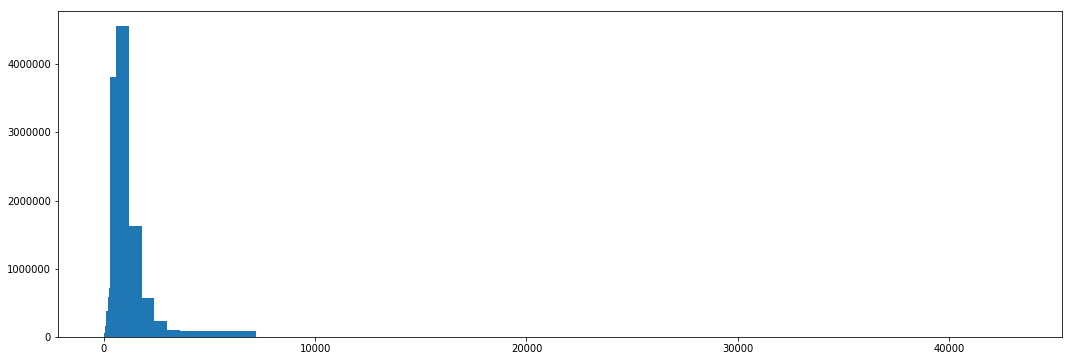

In [29]:
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(111)
bins =[0,1,5,10,60,120,180,240,300,600,1200,1800,2400,3000,3600,7200,10800,21600,43200]
counts, bins, fig = ax1.hist(train.duration, bins=bins)

In [30]:
if False:
    plt.scatter(train.diff_lng, train.duration)
    plt.show()

In [31]:
if False:
    plt.scatter(train.diff_lat, train.duration)
    plt.show()

In [32]:
old_features = train.columns.tolist()

In [33]:
# Create dummy variables for longitutde and latitude

train = train.join(pd.get_dummies(train.start_lng, prefix='start_lng', prefix_sep='_'))
train = train.join(pd.get_dummies(train.start_lat, prefix='start_lat', prefix_sep='_'))
train = train.join(pd.get_dummies(train.end_lng, prefix='end_lng', prefix_sep='_'))
train = train.join(pd.get_dummies(train.end_lat, prefix='end_lat', prefix_sep='_'))

test = test.join(pd.get_dummies(test.start_lng, prefix='start_lng', prefix_sep='_'))
test = test.join(pd.get_dummies(test.start_lat, prefix='start_lat', prefix_sep='_'))
test = test.join(pd.get_dummies(test.end_lng, prefix='end_lng', prefix_sep='_'))
test = test.join(pd.get_dummies(test.end_lat, prefix='end_lat', prefix_sep='_'))

In [34]:
all_columns = train.columns.tolist()
dummy_features = [i for i in all_columns if i not in old_features]
dummy_features_test = [i for i in test.columns.tolist() if i not in old_features]

In [35]:
# Features need to normalize

norm_features = ['diff_lng', 'diff_lat']

### Model Bulding

In [36]:
# Check all features in train is in test

l = [i for i in dummy_features if i not in test.columns.tolist()]
print('%d dummy_features in train not in test.'%len(l))

23 dummy_features in train not in test.


In [37]:
# Check all features in test is in train

l_t = [i for i in dummy_features_test if i not in train.columns.tolist()]
print('%d dummy_features in test not in train.'%len(l_t))

0 dummy_features in test not in train.


In [38]:
from sklearn import preprocessing

train.reset_index(inplace=True)
test.reset_index(inplace=True)
train_features = train[norm_features]
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(train_features)
train_scaled = min_max_scaler.transform(train_features)
test_scaled = min_max_scaler.transform(test[norm_features])
train_norm = pd.DataFrame(train_scaled, columns=norm_features)
test_norm = pd.DataFrame(test_scaled, columns=norm_features)

In [39]:
train_norm.head(3)

,diff_lng,diff_lat
0,0.006507,0.013845
1,0.045108,0.044387
2,0.006809,0.023409


In [40]:
train_norm = train_norm.join(train[['duration', 'is_holiday', 'is_weekend', 'is_rushhour'] + dummy_features_test])
test_norm = test_norm.join(test[['row_id', 'is_holiday', 'is_weekend', 'is_rushhour'] + dummy_features_test])

### Rum multiple times with 20% of train data

In [41]:
if True:
    from sklearn.model_selection import train_test_split
    train_model, validation_model = train_test_split(train_norm, test_size=0.2, random_state=73777)
    train_model = validation_model.copy(deep=True)

In [42]:
test_norm.head(3)

,diff_lng,diff_lat,row_id,is_holiday,is_weekend,is_rushhour,start_lng_-7448,start_lng_-7445,start_lng_-7444,start_lng_-7443,...,end_lat_4094,end_lat_4095,end_lat_4096,end_lat_4097,end_lat_4098,end_lat_4099,end_lat_4100,end_lat_4101,end_lat_4102,end_lat_4103
0,0.010750,0.024540,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.008509,0.019479,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000552,0.014897,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
train_norm.head(3)

,diff_lng,diff_lat,duration,is_holiday,is_weekend,is_rushhour,start_lng_-7448,start_lng_-7445,start_lng_-7444,start_lng_-7443,...,end_lat_4094,end_lat_4095,end_lat_4096,end_lat_4097,end_lat_4098,end_lat_4099,end_lat_4100,end_lat_4101,end_lat_4102,end_lat_4103
0,0.006507,0.013845,112,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.045108,0.044387,1159,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.006809,0.023409,281,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Create features

In [44]:
features = [i for i in train_norm.columns.tolist() if i != 'duration']

In [45]:
# First tried KNN

from sklearn.neighbors import KNeighborsRegressor

if False:
    train_norm, validation_norm = train_test_split(train_norm, test_size=0.2)
    knr = KNeighborsRegressor()
    knr.fit(train_norm[features], train_norm['duration'])
    predictions = knr.predict(validation_norm[features])

In [46]:
# Second tried RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

if False:
    model = RandomForestRegressor(n_jobs=-1, criterion='mae')
    model.fit(train_norm[features], train_norm['duration'])
    predictions = model.predict(validation_norm[features])

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

if True:
    train_model, validation_model = train_test_split(train_model, test_size=0.1)

    lr = LinearRegression()
    lr.fit(train_model[features], train_model['duration'])
    predictions = lr.predict(validation_model[features])
    results = lr.predict(test_norm[features])
    final = test_norm[['row_id', 'is_holiday']].join(pd.DataFrame(results, columns=['duration']))
    final.to_csv('ETA_test_lr_0.2_6.csv')

In [48]:
from sklearn.linear_model import RidgeCV

if False:
    
    rcv = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), scoring='neg_mean_absolute_error', cv=8)
    train_model, validation_model = train_test_split(train_model, test_size=0.1)

    rcv_fit = rcv.fit(train_norm[features], train_norm['duration'])
    predictions = rcv_fit.predict(validation_norm[features])
    results = rcv_fit.predict(test_norm[features])
    final = test_norm[['row_id', 'is_holiday']].join(pd.DataFrame(results, columns=['duration']))
final.to_csv('ETA_test_cv_0.2.csv')

In [49]:
s = 0
count = 0
for i, j in zip(predictions, validation_model['duration']):
    count += 1
    s += abs(i - j)
    
print('Metric for error l1: %.3f.'%(s / count))

Metric for error l1: 287.306.


### Thank you.
### Have a great day.